<a href="https://colab.research.google.com/github/zubair9703/Semantic-Segmentation-on-Sentinel/blob/main/lulc_segmemtation128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is originally adopted from following source:
   https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.6 MB/s 


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Segmentation Models: using `keras` framework.


In [ ]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
train_img_dir = "/content/drive/MyDrive/pacthes/data/aug/train_images/train/"
train_mask_dir = "/content/drive/MyDrive/pacthes/data/aug/train_masks/train/"

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

In [ ]:
num_images = len(os.listdir(train_img_dir))


img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

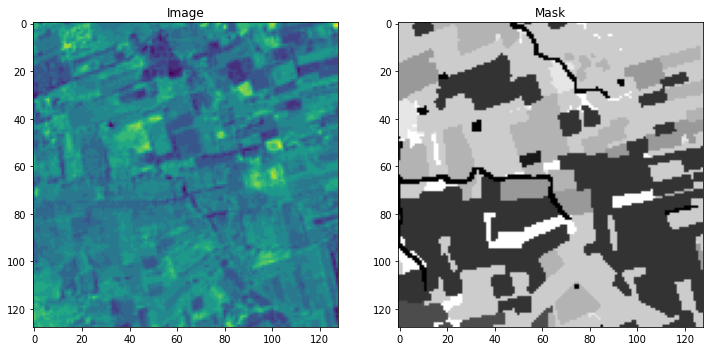

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot[:,:,0])
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
seed=24
batch_size= 16
n_classes=11

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

In [ ]:
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    #img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size=(128, 128),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size=(128, 128),
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path = "/content/drive/MyDrive/pacthes/data/aug/train_images/"
train_mask_path = "/content/drive/MyDrive/pacthes/data/aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=11)

val_img_path = "/content/drive/MyDrive/pacthes/data/aug/val_images/"
val_mask_path = "/content/drive/MyDrive/pacthes/data/aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=11)

Found 700 images belonging to 1 classes.
Found 700 images belonging to 1 classes.


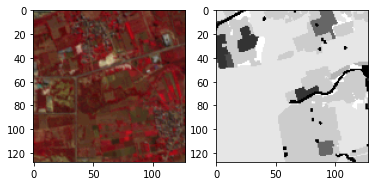

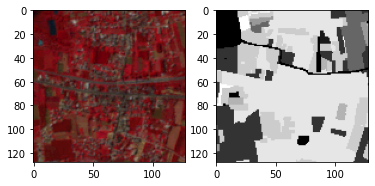

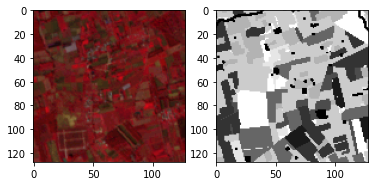

In [ ]:
x, y = train_img_gen.__next__()

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

Found 300 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


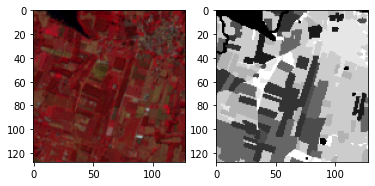

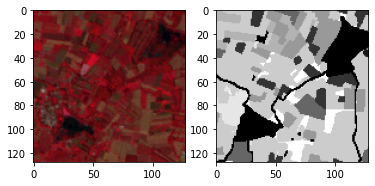

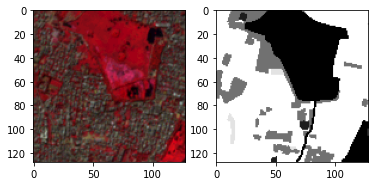

In [ ]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
num_train_imgs = len(os.listdir('/content/drive/MyDrive/pacthes/data/aug/train_images/train/'))
num_val_images = len(os.listdir('/content/drive/MyDrive/pacthes/data/aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

n_classes=11

In [ ]:
sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [ ]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
# model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

#Other losses to try: categorical_focal_dice_loss, cce_jaccard_loss, cce_dice_loss, categorical_focal_loss

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
print(model.input_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=500,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/500
43/43 [==============================] - 9s 172ms/step - loss: 1.9413 - categorical_accuracy: 0.3588 - val_loss: 24.2941 - val_categorical_accuracy: 0.0838
Epoch 2/500
43/43 [==============================] - 7s 165ms/step - loss: 1.6995 - categorical_accuracy: 0.4391 - val_loss: 4.8494 - val_categorical_accuracy: 0.1660
Epoch 3/500
43/43 [==============================] - 7s 165ms/step - loss: 1.6230 - categorical_accuracy: 0.4602 - val_loss: 2.1512 - val_categorical_accuracy: 0.3303
Epoch 4/500
43/43 [==============================] - 7s 165ms/step - loss: 1.6171 - categorical_accuracy: 0.4635 - val_loss: 5.9342 - val_categorical_accuracy: 0.1926
Epoch 5/500
43/43 [==============================] - 7s 165ms/step - loss: 1.5583 - categorical_accuracy: 0.4806 - val_loss: 2.1394 - val_categorical_accuracy: 0.3504
Epoch 6/500
43/43 [==============================] - 7s 165ms/step - loss: 1.5680 - categorical_accuracy: 0.4771 - val_loss: 2.2086 - val_categorical_accuracy: 0.32

In [ ]:
os.chdir("/content/drive/MyDrive/pacthes/output/")
# model.save('landcover_25_epochs_RESNET_backbone_batch16.hdf5')

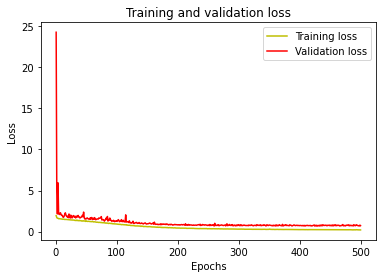

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

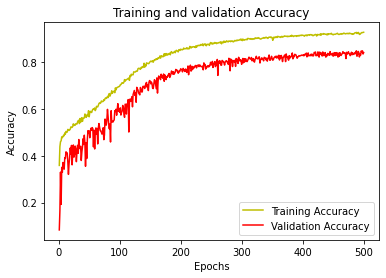

In [ ]:
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

model = load_model("landcover_25_epochs_RESNET_backbone_batch16.hdf5", compile=False)

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 11
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.7570173


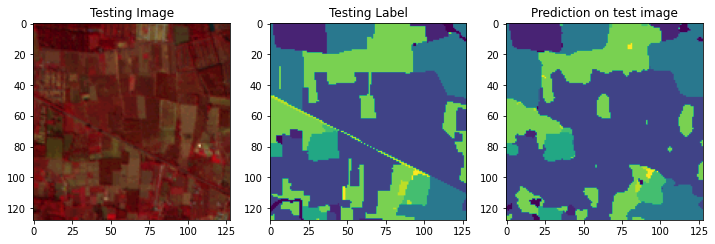

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

s
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

In [ ]:
from skimage.io import imread

In [ ]:
im=imread("/content/drive/MyDrive/pacthes/output/val/images/image_41.tif")
im = scaler.fit_transform(im.reshape(-1, im.shape[-1])).reshape(im.shape)

In [ ]:
im=im.reshape(1,128, 128, 3)
print(im.shape)

(1, 128, 128, 3)


In [ ]:
test_pred_batch = model.predict(im)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

In [ ]:
im=im.reshape(128, 128, 3)
test_pred_batch_argmax=test_pred_batch_argmax.reshape(128,128)

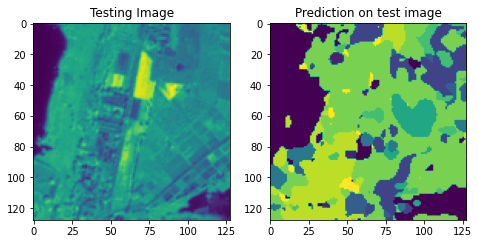

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(im[:,:,0])
plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(test_mask_batch_argmax[img_num])
# plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax)
plt.show()